In [ ]:
import os
import numpy as np
import pandas as pd
import pyfixest as pf
from marginaleffects import slopes
import matplotlib.pyplot as plt

# Panel Regressions: AI Use and Developer Productivity

This notebook estimates fixed-effects panel regressions examining the relationship between AI code assistant usage and developer productivity metrics.

**Input:** `outputs/panel_uq.parquet` (user-quarter panel from `make_panel_data.py`)

**Outputs:** 
- `outputs/main_regressions.pdf` - Main regression coefficient plot
- `outputs/interaction_regressions.pdf` - Experience interaction plot  
- `outputs/placebo_regressions.pdf` - Pre-period placebo plot
- `outputs/ma_extrapolation.pdf` - Measurement error extrapolation plots

In [36]:

# Plot styling
plt.rcParams.update({
    "axes.labelsize": 20,
    "axes.titlesize": 20,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "lines.linewidth": 3,
    "lines.markersize": 8,
    "axes.edgecolor": "black",
    "axes.linewidth": 2,
    "axes.grid": False,
    "figure.figsize": (12, 8),
    "figure.dpi": 300,
    "figure.facecolor": "white"
})

# Paths
DATA_PATH = "outputs/panel_uq.parquet"
OUTDIR = "outputs"
os.makedirs(OUTDIR, exist_ok=True)

# MA windows for robustness checks
MA_WINDOWS = [4, 8, 16, 32]

## Load and Prepare Data

In [37]:
# Load panel data
df = pd.read_parquet(DATA_PATH)
df = df.sort_values(['IDu', 'q']).reset_index(drop=True)

print(f"Panel dimensions: {len(df)} observations, {df['IDu'].nunique()} users")
print(f"Quarter range: {df['q'].min()} to {df['q'].max()}")

Panel dimensions: 510104 observations, 100097 users
Quarter range: 20191 to 20244


In [38]:
# Create derived variables for regressions

# Bin experience (median split)
df['binned_experience'] = pd.qcut(
    df['experience'], 2, labels=False, duplicates='drop'
)

# Bin lagged AI exposure (quintiles)
df['binned_L_AIavF'] = pd.qcut(
    df['L_AIavF'], 5, labels=False, duplicates='drop'
)

# Create subsets
ma32_subset = df[~df['L_AIma32_iF'].isna()].copy()
df_placebo = df[df['q'] < 20221].copy()  # Pre-ChatGPT period

## Helper Functions

In [39]:
def extract_ci(model, term):
    """Extract estimate and 95% CI from model tidy output."""
    t = model.tidy()
    return (
        float(t.loc[term, "Estimate"]),
        float(t.loc[term, "2.5%"]),
        float(t.loc[term, "97.5%"])
    )


def run_main_models(data, regressor="L_AIavF"):
    """Run main regression specifications across all outcome variables."""
    dvs = [
        "log_Cuq", "log_Cuq_mfiles", "log_Cuq_wimprt",
        "log_libQC_all", "log_libkQC_all", "log_libLQ_all", "log_libE_all",
        "log_libQC_new_u", "log_libkQC_new_u", "log_libLQ_new_u", "log_libE_new_u"
    ]
    models = []
    for dv in dvs:
        m = pf.feols(
            f"{dv} ~ {regressor} | IDu + q",
            data=data,
            vcov={'CRV1': 'IDu'}
        )
        models.append(m)
    return models, dvs


def run_interaction_models(data):
    """Run models with experience interaction."""
    dvs = [
        "log_Cuq", "log_Cuq_mfiles", "log_Cuq_wimprt",
        "log_libQC_all", "log_libkQC_all", "log_libLQ_all", "log_libE_all",
        "log_libQC_new_u", "log_libkQC_new_u", "log_libLQ_new_u", "log_libE_new_u"
    ]
    models = []
    for dv in dvs:
        m = pf.feols(
            f"{dv} ~ binned_experience + L_AIavF + binned_experience*L_AIavF | IDu + q",
            data=data,
            vcov={'CRV1': 'IDu'}
        )
        models.append(m)
    return models, dvs


def plot_coefficients(models, regressor, filename, title=None):
    """Create coefficient plot with grouped outcomes."""
    # Extract estimates
    ests, los, his = [], [], []
    for m in models:
        est, lo, hi = extract_ci(m, regressor)
        ests.append(est)
        los.append(lo)
        his.append(hi)
    
    ests = np.array(ests)
    yerr = np.vstack([ests - np.array(los), np.array(his) - ests])
    
    # Labels
    labels = [
        'All', 'Multi-file', 'Imports',
        'Combos', 'Combos\n(Top 5k)', 'Combos\n(Groups)', 'Indiv.\nLibs.',
        'Combos', 'Combos\n(Top 5k)', 'Combos\n(Groups)', 'Indiv.\nLibs.'
    ]
    
    # Group spacing
    group_sizes = [3, 4, 4]
    gap = 0.8
    x_spaced = []
    offset = 0.0
    for gsize in group_sizes:
        x_spaced.extend(offset + np.arange(gsize))
        offset += gsize + gap
    x_spaced = np.array(x_spaced)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12.0, 5.0), dpi=300)
    ax.errorbar(x_spaced, ests, yerr=yerr, fmt="o", capsize=3, color='black')
    ax.axhline(0, lw=1, color="black")
    ax.set_xticks(x_spaced)
    ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=13)
    ax.set_xlim(x_spaced[0] - 0.6, x_spaced[-1] + 0.6)
    ax.set_ylabel("Estimated marginal\neffect of AI use")
    ax.tick_params(axis="y", labelsize=13)
    
    # Group labels
    sec = ax.secondary_xaxis(location=-0.17)
    sec.spines['bottom'].set_visible(False)
    g1_center = x_spaced[0:3].mean()
    g2_center = x_spaced[3:7].mean()
    g3_center = x_spaced[7:11].mean()
    sec.set_xticks(
        [g1_center, g2_center, g3_center],
        labels=['Commits\n(log)', 'Library Use\n(log)', 'Library Entry\n(log)'],
        size=20
    )
    sec.tick_params('x', length=0)
    
    if title:
        plt.title(title)
    
    fig.tight_layout()
    plt.savefig(f'{OUTDIR}/{filename}')
    plt.show()

## Main Results

In [40]:
# Run main regressions
models, dvs = run_main_models(df)

# Display regression table
pf.etable(
    models,
    head_order="hd",
    model_heads=[
        'Commits', 'Commits', 'Commits',
        'Library Use', 'Library Use', 'Library Use', 'Library Use',
        'Library Entry', 'Library Entry', 'Library Entry', 'Library Entry'
    ],
    labels={
        'log_Cuq': 'All Commits (log)',
        'log_Cuq_mfiles': 'Multi-file (log)',
        'log_Cuq_wimprt': 'Imports (log)',
        'log_libQC_all': 'Combos (log)',
        'log_libkQC_all': 'Combos (5k) (log)',
        'log_libLQ_all': 'Combos (groups) (log)',
        'log_libE_all': 'Individual Libs. (log)',
        'log_libQC_new_u': 'Combos (log)',
        'log_libkQC_new_u': 'Combos (5k) (log)',
        'log_libLQ_new_u': 'Combos (groups) (log)',
        'log_libE_new_u': 'Individual Libs. (log)',
        'q': 'Quarter', 'IDu': 'User', 'L_AIavF': 'AI Use'
    },
    notes="Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001."
)

GT(_tbl_data=  level_0               level_1                    0                    1  \
0    coef                AI Use  0.122* <br> (0.048)  0.071* <br> (0.032)   
1      fe               Quarter                    x                    x   
2      fe                  User                    x                    x   
3   stats          Observations               123428               123428   
4   stats             S.E. type              by: IDu              by: IDu   
5   stats         R<sup>2</sup>                0.636                0.621   
6   stats  R<sup>2</sup> Within                0.000                0.000   

                     2                    3                    4  \
0  0.074* <br> (0.032)  0.100* <br> (0.040)  0.093* <br> (0.039)   
1                    x                    x                    x   
2                    x                    x                    x   
3               123428               123428               123428   
4              by: IDu              by: IDu              by: IDu   
5                0.610                0.606                0.604   
6                0.000                0.000                0.000   

                     5                    6                    7  \
0  0.082* <br> (0.036)  0.118* <br> (0.049)  0.093* <br> (0.040)   
1                    x                    x                    x   
2                    x                    x                    x   
3               123428               123428               123428   
4              by: IDu              by: IDu              by: IDu   
5                0.595                0.586                0.596   
6                0.000                0.000                0.000   

                     8                   9                  10  
0  0.082* <br> (0.039)  0.057 <br> (0.033)  0.045 <br> (0.041)  
1                    x                   x                   x  
2                    x                   x                   x  
3               123428              123428              123428  
4              by: IDu             by: IDu             by: IDu  
5                0.593               0.534               0.497  
6                0.000               0.000               0.000  , _body=<great_tables._gt_data.Body object at 0x6a78b1850>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTypeEnum.default: 1>, column_label='(6)', column_align='center', column_width=None), ColInfo(var='6', type=<ColInfoTypeEnum.default: 1>, column_label='(7)', column_align='center', column_width=None), ColInfo(var='7', type=<ColInfoTypeEnum.default: 1>, column_label='(8)', column_align='center', column_width=None), ColInfo(var='8', type=<ColInfoTypeEnum.default: 1>, column_label='(9)', column_align='center', column_width=None), ColInfo(var='9', type=<ColInfoTypeEnum.default: 1>, column_label='(10)', column_align='center', column_width=None), ColInfo(var='10', type=<ColInfoTypeEnum.default: 1>, column_label='(11)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x6bce2e660>, _spanners=Spanners([SpannerInfo(spanner_id='Commits', spanner_level=2, spanner_label='Commits', spanner_un

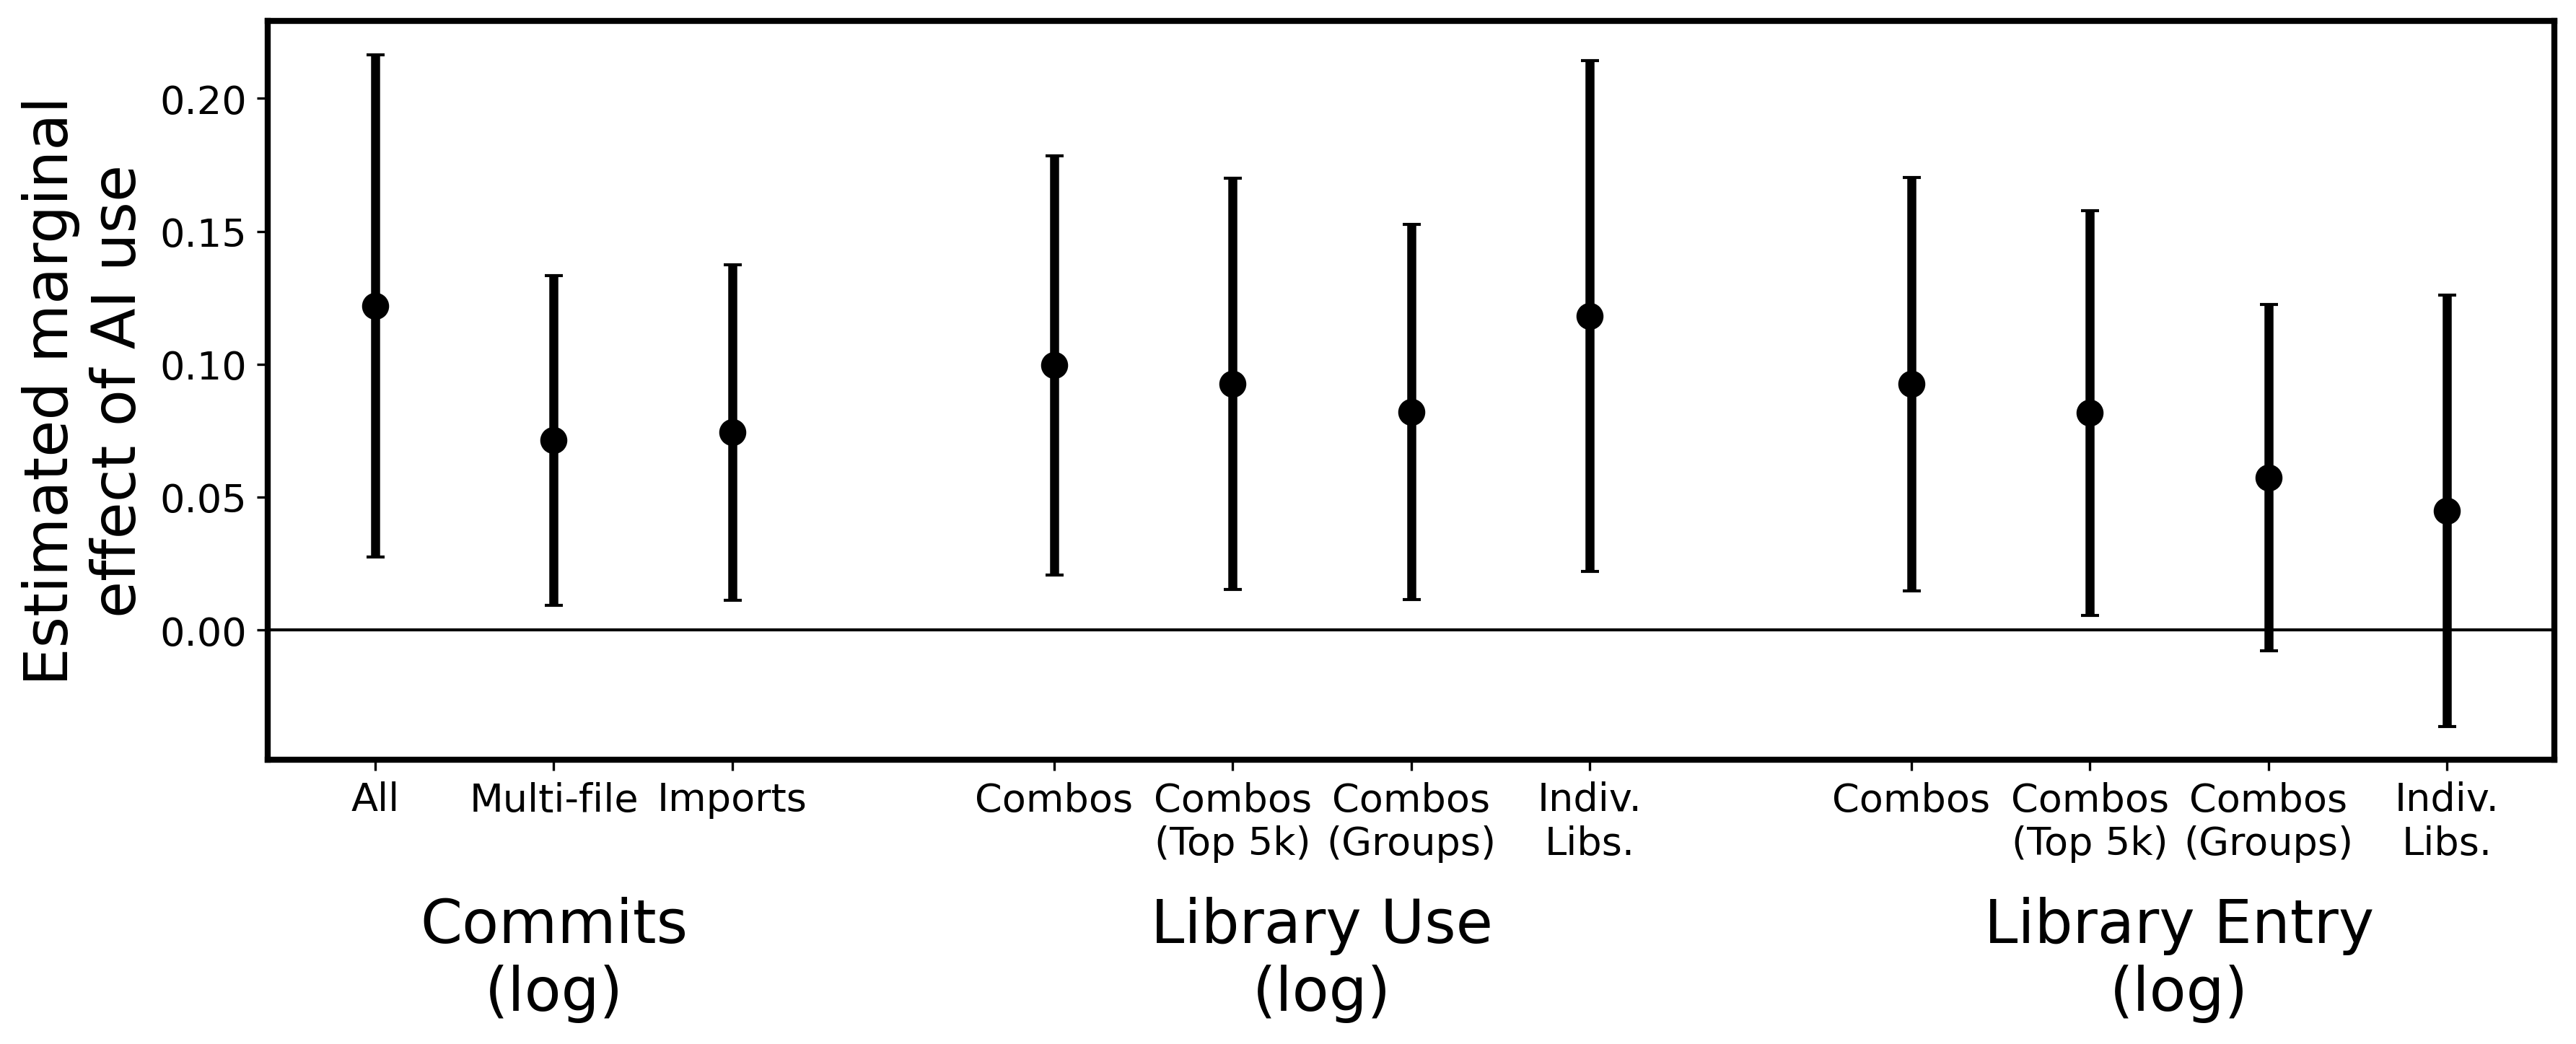

In [41]:
# Coefficient plot
plot_coefficients(models, 'L_AIavF', 'main_regressions.pdf')

In [42]:
# LaTeX table output
print(
    pf.etable(
        models,
        head_order="hd",
        model_heads=[
            'Commits', 'Commits', 'Commits',
            'Library Use', 'Library Use', 'Library Use', 'Library Use',
            'Library Entry', 'Library Entry', 'Library Entry', 'Library Entry'
        ],
        labels={
            'log_Cuq': 'All Commits (log)',
            'log_Cuq_mfiles': 'Multi-file (log)',
            'log_Cuq_wimprt': 'Imports (log)',
            'log_libQC_all': 'Combos (log)',
            'log_libkQC_all': 'Combos (5k) (log)',
            'log_libLQ_all': 'Combos (groups) (log)',
            'log_libE_all': 'Individual Libs. (log)',
            'log_libQC_new_u': 'Combos (log)',
            'log_libkQC_new_u': 'Combos (5k) (log)',
            'log_libLQ_new_u': 'Combos (groups) (log)',
            'log_libE_new_u': 'Individual Libs. (log)',
            'q': 'Quarter', 'IDu': 'User', 'L_AIavF': 'AI Use'
        },
        notes="Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001.",
        type="tex"
    )
)

\renewcommand\cellalign{t}
\begin{threeparttable}
\begin{tabular}{lcccccccccccc}
\toprule
 & \multicolumn{3}{c}{Commits} & \multicolumn{4}{c}{Library Use} & \multicolumn{4}{c}{Library Entry} \\
\cmidrule(lr){2-4} \cmidrule(lr){5-8} \cmidrule(lr){9-12} 
 & All Commits (log) & Multi-file (log) & Imports (log) & Combos (log) & Combos (5k) (log) & Combos (groups) (log) & Individual Libs. (log) & Combos (log) & Combos (5k) (log) & Combos (groups) (log) & Individual Libs. (log) \\
 & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) & (10) & (11) \\
\midrule
\addlinespace
AI Use & \makecell{0.122* \\ (0.048)} & \makecell{0.071* \\ (0.032)} & \makecell{0.074* \\ (0.032)} & \makecell{0.100* \\ (0.040)} & \makecell{0.093* \\ (0.039)} & \makecell{0.082* \\ (0.036)} & \makecell{0.118* \\ (0.049)} & \makecell{0.093* \\ (0.040)} & \makecell{0.082* \\ (0.039)} & \makecell{0.057 \\ (0.033)} & \makecell{0.045 \\ (0.041)} \\
\midrule
\addlinespace
Quarter & x & x & x & x & x & x & x & x & x & x & x \

## Experience Interaction Models

In [43]:
# Run interaction models
int_models, dvs = run_interaction_models(df)

# Display table
pf.etable(
    int_models,
    head_order="hd",
    model_heads=[
        'Commits', 'Commits', 'Commits',
        'Library Use', 'Library Use', 'Library Use', 'Library Use',
        'Library Entry', 'Library Entry', 'Library Entry', 'Library Entry'
    ],
    labels={
        'q': 'Quarter', 'IDu': 'User', 'L_AIavF': 'AI Use'
    },
    notes="Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001."
)

GT(_tbl_data=  level_0                          level_1                    0  \
0    coef                binned_experience  -0.027 <br> (0.044)   
1    coef                           AI Use   0.020 <br> (0.064)   
2    coef  binned_experience &#215; AI Use  0.189* <br> (0.086)   
3      fe                          Quarter                    x   
4      fe                             User                    x   
5   stats                     Observations               123428   
6   stats                        S.E. type              by: IDu   
7   stats                    R<sup>2</sup>                0.636   
8   stats             R<sup>2</sup> Within                0.000   

                       1                     2                     3  \
0    -0.028 <br> (0.028)   -0.016 <br> (0.029)   -0.030 <br> (0.036)   
1    -0.030 <br> (0.040)   -0.018 <br> (0.041)   -0.001 <br> (0.051)   
2  0.188*** <br> (0.055)  0.171** <br> (0.056)  0.187** <br> (0.071)   
3                      x                     x                     x   
4                      x                     x                     x   
5                 123428                123428                123428   
6                by: IDu               by: IDu               by: IDu   
7                  0.621                 0.610                 0.606   
8                  0.000                 0.000                 0.000   

                      4                     5                    6  \
0   -0.029 <br> (0.035)   -0.022 <br> (0.032)  -0.024 <br> (0.043)   
1   -0.004 <br> (0.051)   -0.008 <br> (0.046)   0.004 <br> (0.064)   
2  0.179** <br> (0.069)  0.166** <br> (0.063)  0.211* <br> (0.086)   
3                     x                     x                    x   
4                     x                     x                    x   
5                123428                123428               123428   
6               by: IDu               by: IDu              by: IDu   
7                 0.605                 0.595                0.586   
8                 0.000                 0.000                0.000   

                      7                     8                     9  \
0   -0.035 <br> (0.036)   -0.035 <br> (0.035)   -0.023 <br> (0.030)   
1   -0.013 <br> (0.051)   -0.018 <br> (0.050)   -0.034 <br> (0.043)   
2  0.196** <br> (0.069)  0.186** <br> (0.068)  0.169** <br> (0.059)   
3                     x                     x                     x   
4                     x                     x                     x   
5                123428                123428                123428   
6               by: IDu               by: IDu               by: IDu   
7                 0.597                 0.593                 0.534   
8                 0.000                 0.000                 0.000   

                    10  
0  -0.026 <br> (0.036)  
1  -0.052 <br> (0.055)  
2  0.179* <br> (0.073)  
3                    x  
4                    x  
5               123428  
6              by: IDu  
7                0.497  
8                0.000  , _body=<great_tables._gt_data.Body object at 0x3bdcf86b0>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None), ColInfo(var='4', type=<ColInfoTypeEnum.default: 1>, column_label='(5)', column_align='center', column_width=None), ColInfo(var='5', type=<ColInfoTy

In [44]:
# LaTeX output for interaction models
print(
    pf.etable(
        int_models,
        head_order="hd",
        model_heads=[
            'Commits', 'Commits', 'Commits',
            'Library Use', 'Library Use', 'Library Use', 'Library Use',
            'Library Entry', 'Library Entry', 'Library Entry', 'Library Entry'
        ],
        labels={'q': 'Quarter', 'IDu': 'User', 'L_AIavF': 'AI Use'},
        notes="Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001.",
        type="tex"
    )
)

\renewcommand\cellalign{t}
\begin{threeparttable}
\begin{tabular}{lcccccccccccc}
\toprule
 & \multicolumn{3}{c}{Commits} & \multicolumn{4}{c}{Library Use} & \multicolumn{4}{c}{Library Entry} \\
\cmidrule(lr){2-4} \cmidrule(lr){5-8} \cmidrule(lr){9-12} 
 & log_Cuq & log_Cuq_mfiles & log_Cuq_wimprt & log_libQC_all & log_libkQC_all & log_libLQ_all & log_libE_all & log_libQC_new_u & log_libkQC_new_u & log_libLQ_new_u & log_libE_new_u \\
 & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) & (10) & (11) \\
\midrule
\addlinespace
binned_experience & \makecell{-0.027 \\ (0.044)} & \makecell{-0.028 \\ (0.028)} & \makecell{-0.016 \\ (0.029)} & \makecell{-0.030 \\ (0.036)} & \makecell{-0.029 \\ (0.035)} & \makecell{-0.022 \\ (0.032)} & \makecell{-0.024 \\ (0.043)} & \makecell{-0.035 \\ (0.036)} & \makecell{-0.035 \\ (0.035)} & \makecell{-0.023 \\ (0.030)} & \makecell{-0.026 \\ (0.036)} \\
AI Use & \makecell{0.020 \\ (0.064)} & \makecell{-0.030 \\ (0.040)} & \makecell{-0.018 \\ (0.041)} & \make

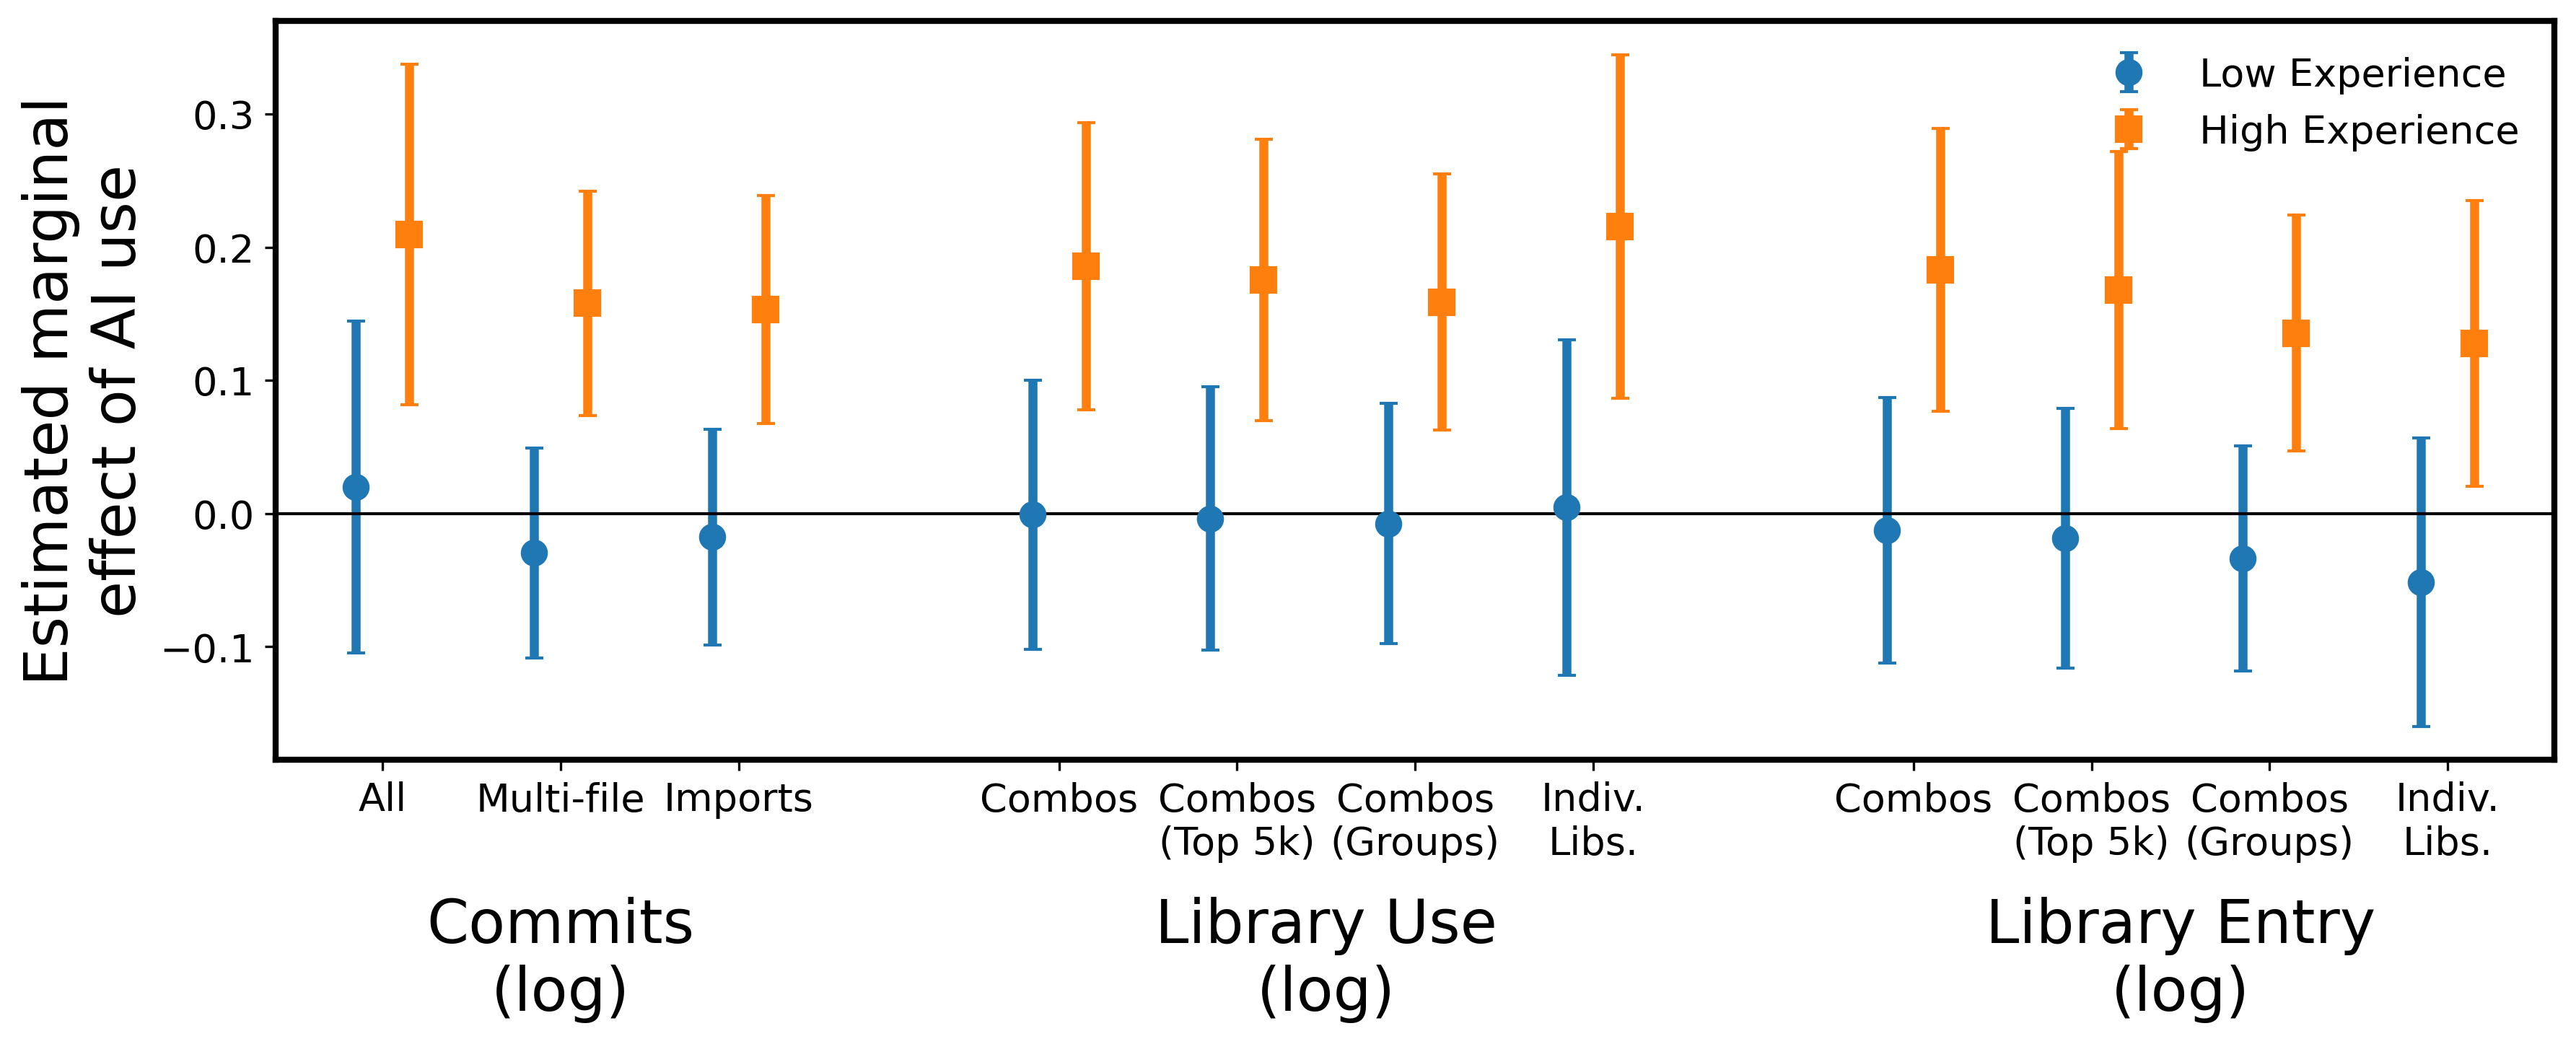

In [45]:
# Plot interaction effects by experience group
def plot_interaction_effects(models):
    """Plot AI effect separately for low/high experience groups."""
    labels = [
        'All', 'Multi-file', 'Imports',
        'Combos', 'Combos\n(Top 5k)', 'Combos\n(Groups)', 'Indiv.\nLibs.',
        'Combos', 'Combos\n(Top 5k)', 'Combos\n(Groups)', 'Indiv.\nLibs.'
    ]
    
    # Extract slopes by experience group
    low_ests, low_los, low_his = [], [], []
    high_ests, high_los, high_his = [], [], []
    
    for m in models:
        sl = slopes(m, variables='L_AIavF', by='binned_experience', vcov=True).to_pandas()
        sl['binned_experience'] = sl['binned_experience'].astype(int)
        sl = sl.sort_values('binned_experience')
        
        low = sl[sl['binned_experience'] == 0].iloc[0]
        high = sl[sl['binned_experience'] == 1].iloc[0]
        
        low_ests.append(low['estimate'])
        low_los.append(low['conf_low'])
        low_his.append(low['conf_high'])
        high_ests.append(high['estimate'])
        high_los.append(high['conf_low'])
        high_his.append(high['conf_high'])
    
    low_ests = np.array(low_ests)
    high_ests = np.array(high_ests)
    low_yerr = np.vstack([low_ests - np.array(low_los), np.array(low_his) - low_ests])
    high_yerr = np.vstack([high_ests - np.array(high_los), np.array(high_his) - high_ests])
    
    # Spacing
    group_sizes = [3, 4, 4]
    gap = 0.8
    x_spaced = []
    offset = 0.0
    for gsize in group_sizes:
        x_spaced.extend(offset + np.arange(gsize))
        offset += gsize + gap
    x_spaced = np.array(x_spaced)
    
    # Plot
    fig, ax = plt.subplots(figsize=(12.0, 5.0), dpi=300)
    width = 0.15
    
    ax.errorbar(x_spaced - width, low_ests, yerr=low_yerr, fmt="o", capsize=3, 
                color='#1f77b4', label='Low Experience')
    ax.errorbar(x_spaced + width, high_ests, yerr=high_yerr, fmt="s", capsize=3,
                color='#ff7f0e', label='High Experience')
    
    ax.axhline(0, lw=1, color="black")
    ax.set_xticks(x_spaced)
    ax.set_xticklabels(labels, rotation=0, ha="center", fontsize=13)
    ax.set_xlim(x_spaced[0] - 0.6, x_spaced[-1] + 0.6)
    ax.set_ylabel("Estimated marginal\neffect of AI use")
    ax.legend(frameon=False, fontsize=13)
    ax.tick_params(axis="y", labelsize=13)
    
    # Group labels
    sec = ax.secondary_xaxis(location=-0.17)
    sec.spines['bottom'].set_visible(False)
    sec.set_xticks(
        [x_spaced[0:3].mean(), x_spaced[3:7].mean(), x_spaced[7:11].mean()],
        labels=['Commits\n(log)', 'Library Use\n(log)', 'Library Entry\n(log)'],
        size=20
    )
    sec.tick_params('x', length=0)
    
    fig.tight_layout()
    plt.savefig(f'{OUTDIR}/interaction_regressions.pdf')
    plt.show()

plot_interaction_effects(int_models)

## Nonlinearity Check (Quintile Dummies)

In [46]:
# Run nonlinearity models with quintile dummies
dvs = [
    "log_Cuq", "log_Cuq_mfiles", "log_Cuq_wimprt",
    "log_libQC_all", "log_libkQC_all", "log_libLQ_all", "log_libE_all",
    "log_libQC_new_u", "log_libkQC_new_u", "log_libLQ_new_u", "log_libE_new_u"
]

nonlin_models = []
for dv in dvs:
    m = pf.feols(
        f"{dv} ~ C(binned_L_AIavF) | IDu + q",
        data=df,
        vcov={'CRV1': 'IDu'}
    )
    nonlin_models.append(m)

pf.etable(nonlin_models, coef_fmt="b \n (se) \n [p]")

GT(_tbl_data=  level_0                   level_1                                  0  \
0    coef  C(binned_L_AIavF)[T.1.0]   0.065* <br> (0.033) <br> [0.045]   
1    coef  C(binned_L_AIavF)[T.2.0]  0.109** <br> (0.034) <br> [0.001]   
2    coef  C(binned_L_AIavF)[T.3.0]   0.084* <br> (0.036) <br> [0.020]   
3    coef  C(binned_L_AIavF)[T.4.0]   0.093* <br> (0.039) <br> [0.017]   
4      fe                         q                                  x   
5      fe                       IDu                                  x   
6   stats              Observations                             123428   
7   stats                 S.E. type                            by: IDu   
8   stats             R<sup>2</sup>                              0.636   
9   stats      R<sup>2</sup> Within                              0.000   

                                   1                                  2  \
0    0.037 <br> (0.021) <br> [0.073]   0.050* <br> (0.021) <br> [0.019]   
1  0.057** <br> (0.021) <br> [0.008]  0.066** <br> (0.022) <br> [0.003]   
2   0.054* <br> (0.023) <br> [0.018]  0.062** <br> (0.023) <br> [0.007]   
3   0.052* <br> (0.026) <br> [0.041]   0.054* <br> (0.026) <br> [0.038]   
4                                  x                                  x   
5                                  x                                  x   
6                             123428                             123428   
7                            by: IDu                            by: IDu   
8                              0.621                              0.610   
9                              0.000                              0.000   

                                   3                                  4  \
0    0.043 <br> (0.027) <br> [0.104]    0.042 <br> (0.026) <br> [0.104]   
1  0.077** <br> (0.027) <br> [0.005]  0.073** <br> (0.027) <br> [0.007]   
2  0.077** <br> (0.029) <br> [0.008]   0.069* <br> (0.029) <br> [0.015]   
3    0.059 <br> (0.033) <br> [0.072]    0.054 <br> (0.032) <br> [0.093]   
4                                  x                                  x   
5                                  x                                  x   
6                             123428                             123428   
7                            by: IDu                            by: IDu   
8                              0.606                              0.604   
9                              0.000                              0.000   

                                   5                                  6  \
0    0.038 <br> (0.023) <br> [0.109]    0.063 <br> (0.033) <br> [0.055]   
1  0.071** <br> (0.025) <br> [0.004]  0.097** <br> (0.034) <br> [0.004]   
2   0.067* <br> (0.026) <br> [0.011]  0.103** <br> (0.036) <br> [0.004]   
3    0.043 <br> (0.029) <br> [0.138]    0.068 <br> (0.040) <br> [0.089]   
4                                  x                                  x   
5                                  x                                  x   
6                             123428                             123428   
7                            by: IDu                            by: IDu   
8                              0.595                              0.586   
9                              0.000                              0.000   

                                   7                                  8  \
0    0.046 <br> (0.026) <br> [0.080]    0.043 <br> (0.026) <br> [0.095]   
1  0.077** <br> (0.027) <br> [0.004]  0.069** <br> (0.027) <br> [0.009]   
2  0.076** <br> (0.029) <br> [0.008]   0.065* <br> (0.028) <br> [0.021]   
3    0.055 <br> (0.032) <br> [0.085]    0.047 <br> (0.031) <br> [0.136]   
4                                  x                                  x   
5                                  x                                  x   
6                             123428                             123428   
7                            by: IDu                            by: IDu   
8                  

## Placebo Test (Pre-ChatGPT Period)

In [47]:
# Run placebo regressions on pre-2022Q1 data
placebo_models, _ = run_main_models(df_placebo)

# Display table
print(
    pf.etable(
        placebo_models,
        head_order="hd",
        model_heads=[
            'Commits', 'Commits', 'Commits',
            'Library Use', 'Library Use', 'Library Use', 'Library Use',
            'Library Entry', 'Library Entry', 'Library Entry', 'Library Entry'
        ],
        labels={'q': 'Quarter', 'IDu': 'User', 'L_AIavF': 'AI Use'},
        notes="Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001.",
        type="tex"
    )
)

\renewcommand\cellalign{t}
\begin{threeparttable}
\begin{tabular}{lcccccccccccc}
\toprule
 & \multicolumn{3}{c}{Commits} & \multicolumn{4}{c}{Library Use} & \multicolumn{4}{c}{Library Entry} \\
\cmidrule(lr){2-4} \cmidrule(lr){5-8} \cmidrule(lr){9-12} 
 & log_Cuq & log_Cuq_mfiles & log_Cuq_wimprt & log_libQC_all & log_libkQC_all & log_libLQ_all & log_libE_all & log_libQC_new_u & log_libkQC_new_u & log_libLQ_new_u & log_libE_new_u \\
 & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) & (10) & (11) \\
\midrule
\addlinespace
AI Use & \makecell{0.136 \\ (0.085)} & \makecell{0.008 \\ (0.050)} & \makecell{0.004 \\ (0.051)} & \makecell{0.030 \\ (0.064)} & \makecell{0.027 \\ (0.063)} & \makecell{0.015 \\ (0.058)} & \makecell{0.015 \\ (0.080)} & \makecell{0.027 \\ (0.064)} & \makecell{0.017 \\ (0.063)} & \makecell{-0.005 \\ (0.055)} & \makecell{-0.052 \\ (0.070)} \\
\midrule
\addlinespace
Quarter & x & x & x & x & x & x & x & x & x & x & x \\
User & x & x & x & x & x & x & x & x & x & x & x

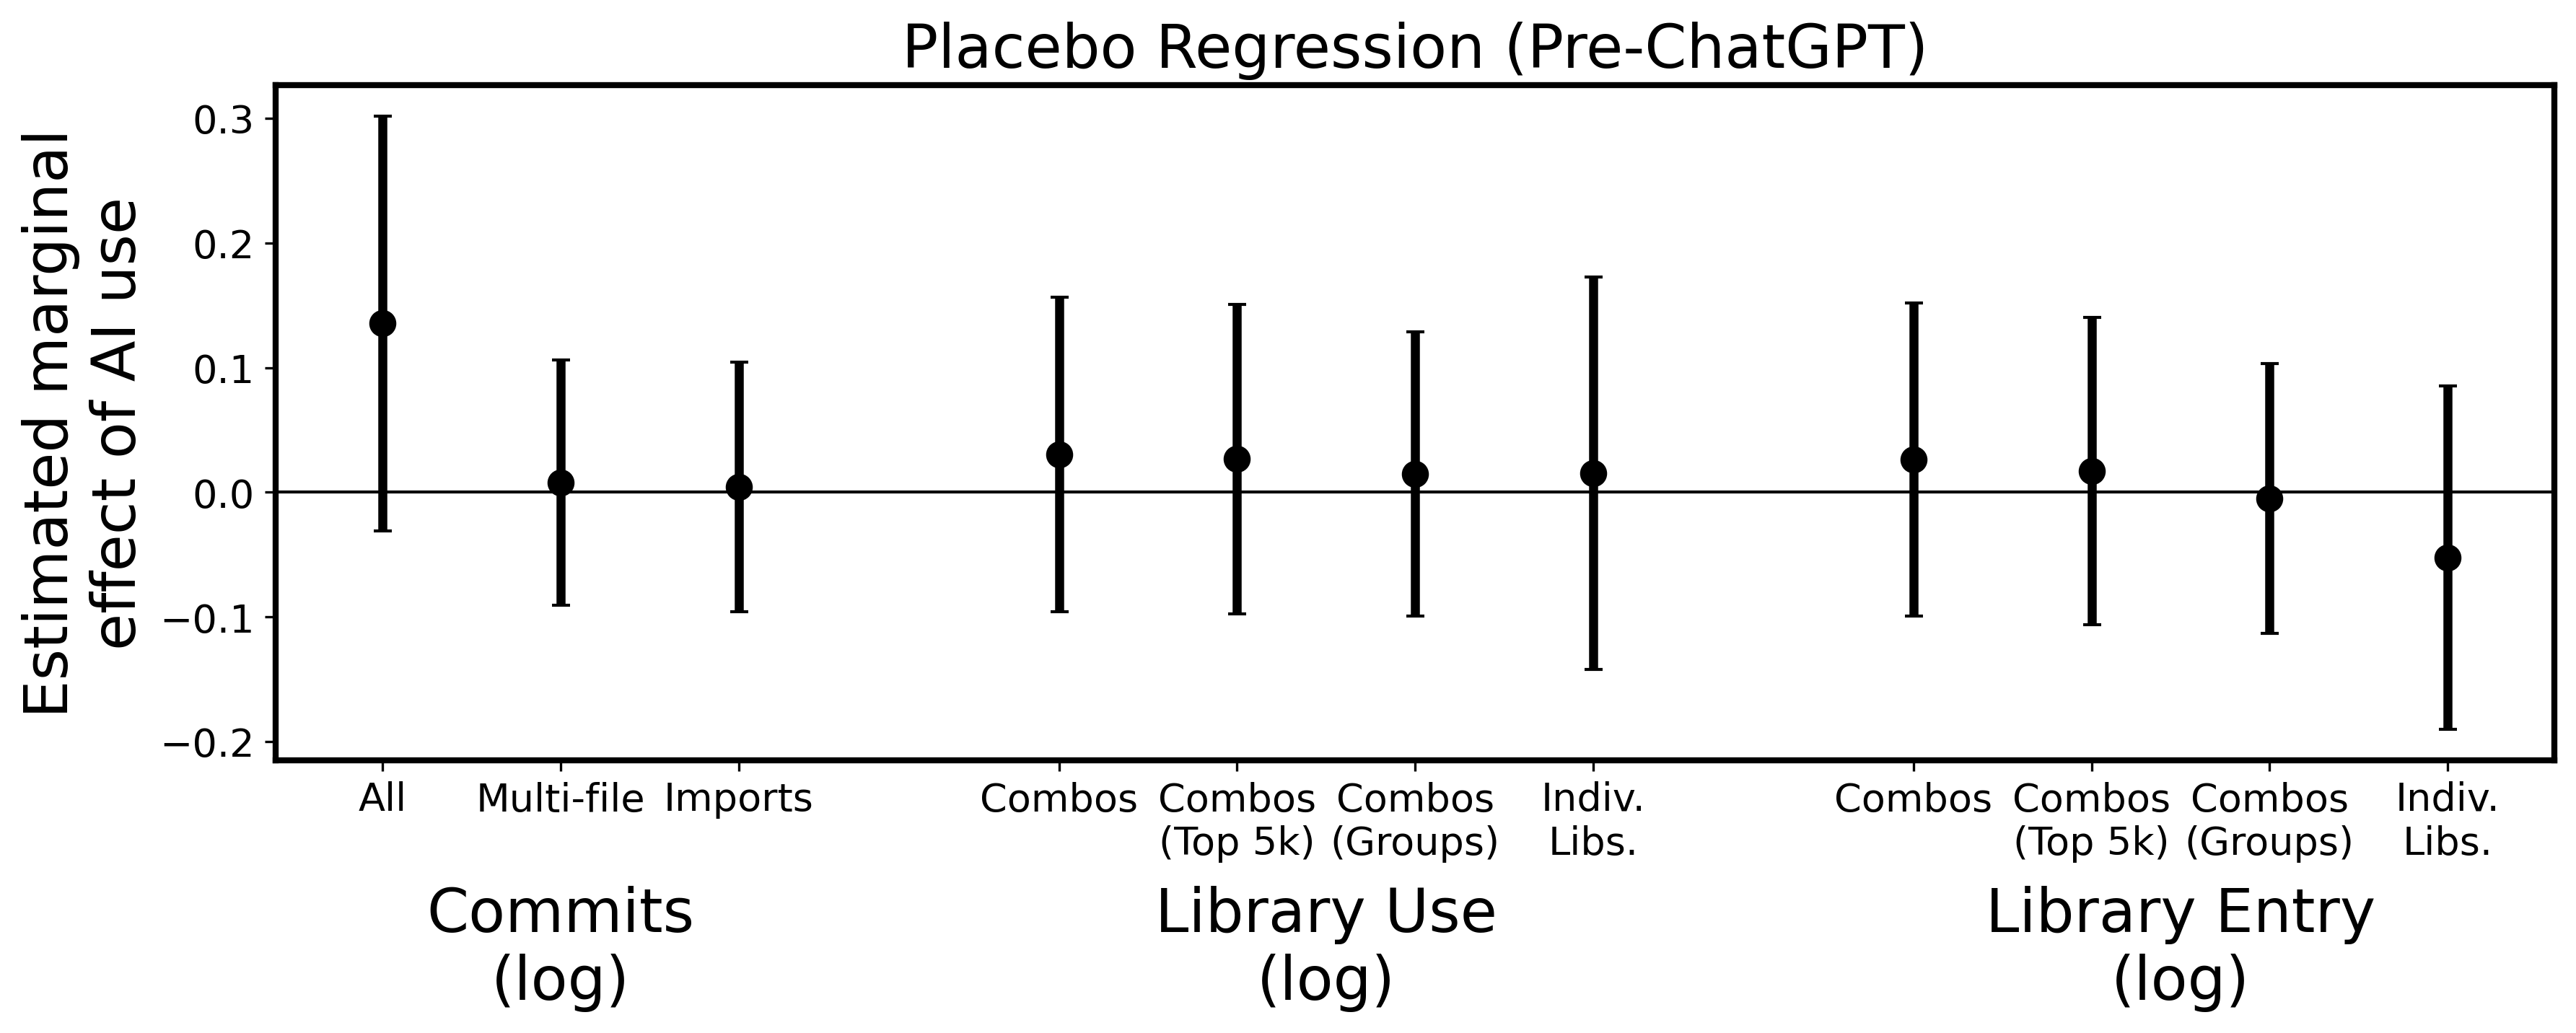

In [48]:
# Placebo coefficient plot
plot_coefficients(
    placebo_models, 'L_AIavF', 'placebo_regressions.pdf',
    title='Placebo Regression (Pre-ChatGPT)'
)

## Measurement Error: MA Window Extrapolation

Test robustness of estimates across different moving average windows for AI exposure.
Longer windows reduce measurement error; extrapolating to infinite window (1/w → 0)
gives the measurement-error-corrected estimate.

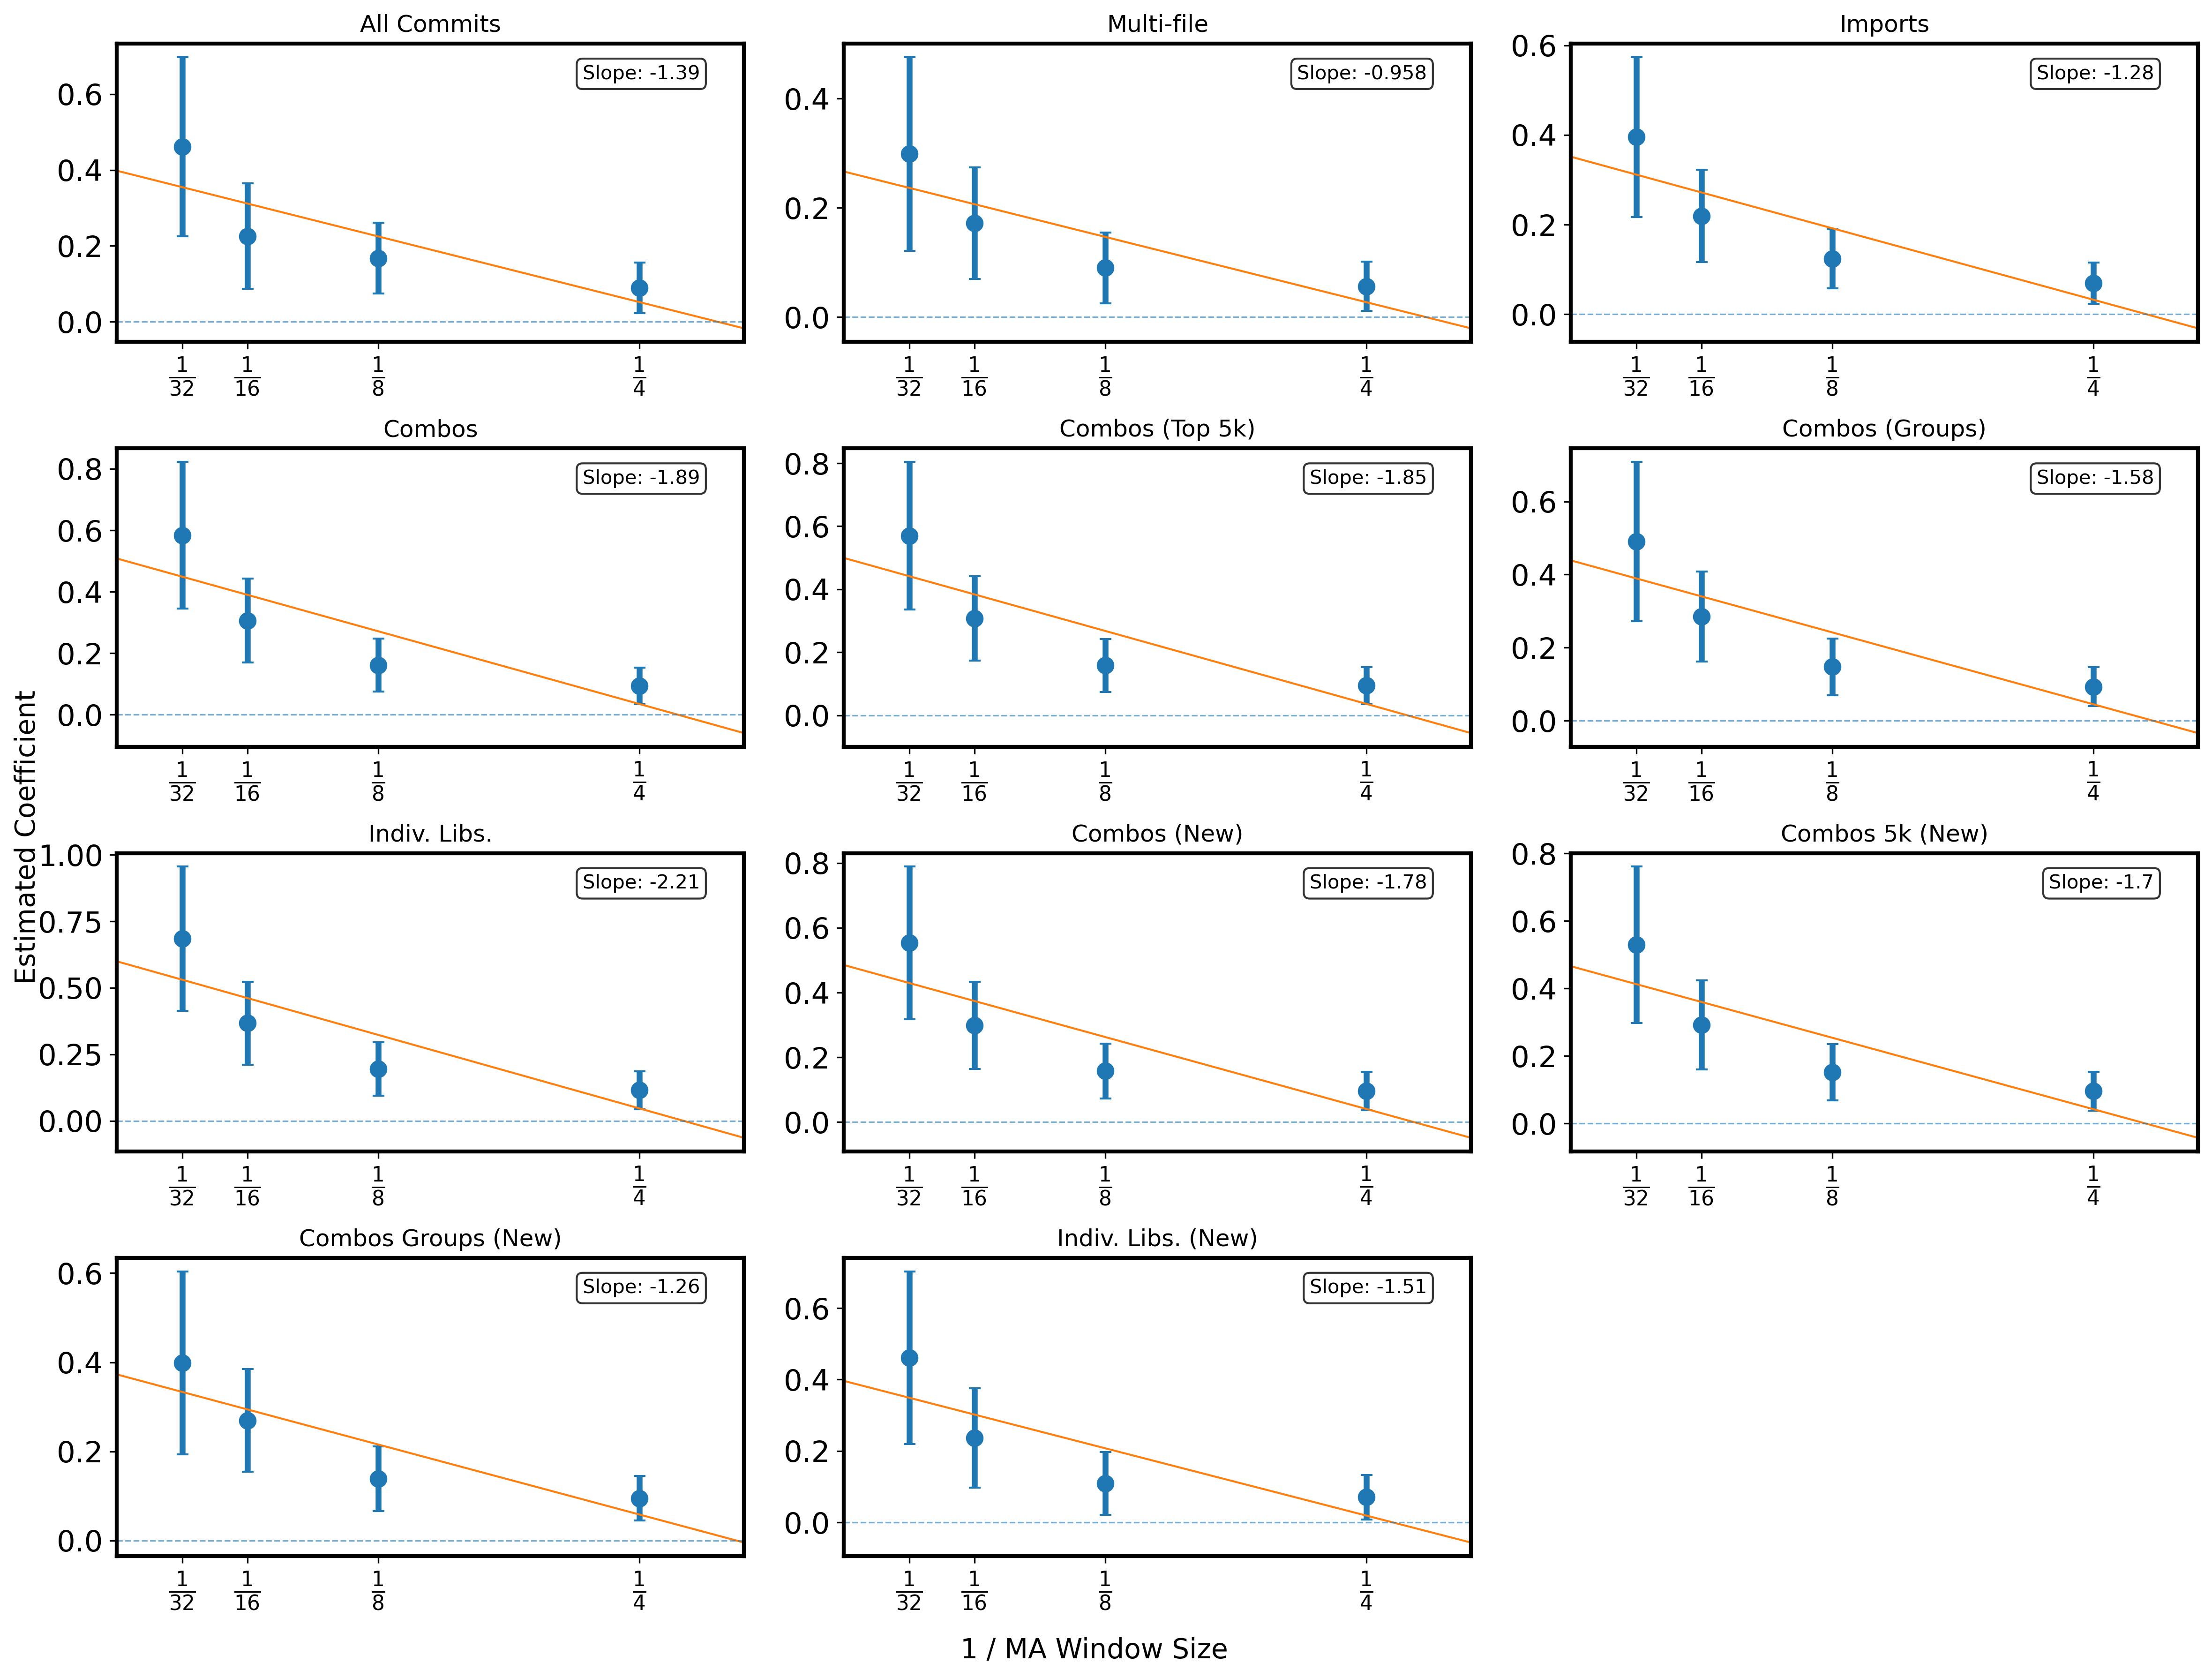

In [49]:
def ma_col(w):
    """Get MA column name for window w."""
    return f"L_AIma{w}_iF"


def compute_ma_series(data, dv):
    """Compute estimates across MA windows for extrapolation."""
    xs, ests, los, his = [], [], [], []
    for w in MA_WINDOWS:
        reg = ma_col(w)
        m = pf.feols(f"{dv} ~ {reg} | IDu + q", data=data, vcov={'CRV1': 'IDu'})
        est, lo, hi = extract_ci(m, reg)
        xs.append(1.0 / w)
        ests.append(est)
        los.append(lo)
        his.append(hi)
    return np.array(xs), np.array(ests), np.array(los), np.array(his)


def plot_ma_extrapolation():
    """Create MA extrapolation plots for all DVs."""
    dvs = [
        "log_Cuq", "log_Cuq_mfiles", "log_Cuq_wimprt",
        "log_libQC_all", "log_libkQC_all", "log_libLQ_all", "log_libE_all",
        "log_libQC_new_u", "log_libkQC_new_u", "log_libLQ_new_u", "log_libE_new_u"
    ]
    titles = [
        'All Commits', 'Multi-file', 'Imports',
        'Combos', 'Combos (Top 5k)', 'Combos (Groups)', 'Indiv. Libs.',
        'Combos (New)', 'Combos 5k (New)', 'Combos Groups (New)', 'Indiv. Libs. (New)'
    ]
    
    xticks = [1/32, 1/16, 1/8, 1/4]
    xticklabels = [r"$\frac{1}{32}$", r"$\frac{1}{16}$", r"$\frac{1}{8}$", r"$\frac{1}{4}$"]
    
    fig, axes = plt.subplots(4, 3, figsize=(16, 12), dpi=300)
    axes = axes.flatten()
    
    for i, (dv, title) in enumerate(zip(dvs, titles)):
        if i >= len(axes):
            break
        ax = axes[i]
        xs, ests, los, his = compute_ma_series(df, dv)
        
        # Fit extrapolation line
        coeffs = np.polyfit(xs, ests, deg=1)
        a, b = coeffs[1], coeffs[0]
        x_line = np.linspace(0, 0.3, 200)
        y_line = a + b * x_line
        
        # Plot
        yerr = np.vstack([ests - los, his - ests])
        ax.errorbar(xs, ests, yerr=yerr, fmt="o", capsize=3)
        ax.plot(x_line, y_line, linewidth=1)
        ax.axhline(0, linewidth=0.8, linestyle="--", alpha=0.6)
        
        ax.set_xlim(0, 0.3)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.set_title(title, fontsize=12)
        ax.text(
            0.93, 0.93, f"Slope: {b:.3g}",
            transform=ax.transAxes, ha="right", va="top",
            fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )
    
    # Hide unused subplot
    axes[-1].axis('off')
    
    fig.supxlabel('1 / MA Window Size', fontsize=14)
    fig.supylabel('Estimated Coefficient', fontsize=14)
    fig.tight_layout()
    plt.savefig(f'{OUTDIR}/ma_extrapolation.pdf')
    plt.show()

plot_ma_extrapolation()